SECTION 1: INITIAL CODE

      input1    input2         output
0   0.319404  0.762959   1.322677e-79
1   0.574329  0.879898   1.033078e-46
2   0.731024  0.733000   7.710875e-16
3   0.840353  0.264732  3.341771e-124
4   0.650114  0.681526  -3.606063e-03
5   0.410437  0.147554  -2.159249e-54
6   0.312691  0.078723  -2.089093e-91
7   0.683418  0.861057   2.535001e-40
8   0.082507  0.403488   3.606771e-81
9   0.883890  0.582254   6.229856e-48
10  0.900482  0.469967  -3.238312e-70
11  0.862435  0.435286  -2.665550e-65
12  0.093113  0.315207  -6.534562e-84
13  0.489754  0.168448   1.332085e-48
14  0.901327  0.673665   2.942125e-55
15  0.321017  0.634971   8.335161e-40
16  0.320447  0.420307  -5.039820e-08
17  0.638618  0.738397  -2.010077e-09
18  0.596486  0.614080   6.591476e-02
19  0.483667  0.319428   5.595491e-11
20  0.962275  0.908318  4.509544e-133
21  0.469376  0.553139  -4.052801e-15
22  0.069389  0.626719 -7.409586e-118
23  0.596409  0.816734   8.491320e-27
24  0.140911  0.317933  -8.805509e-64
25  0.586535

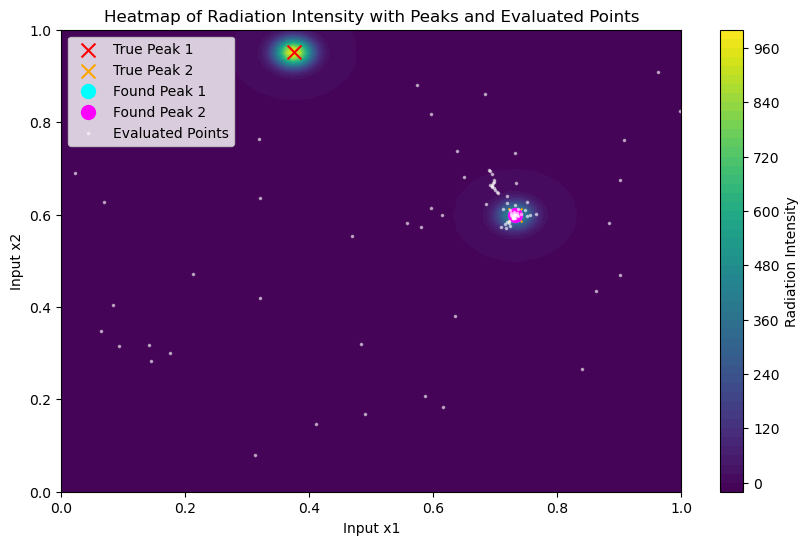

In [2]:
# Check for required libraries and install if missing
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from skopt import gp_minimize
    from skopt.space import Real
    from skopt.utils import use_named_args
except ImportError as e:
    print(f"Error: {e}")
    print("Installing required libraries...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy", "matplotlib", "seaborn", "scikit-optimize"])
    # Re-import after installation
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from skopt import gp_minimize
    from skopt.space import Real
    from skopt.utils import use_named_args
    print("Libraries installed successfully!")

############################################
# this piece of code was provided by a team mate to help automatically extract the queries and observation and remove any duplicates
function = 1
# Read the files
X_init = np.load("initial_inputs.npy")
y_init = np.load("initial_outputs.npy")
queries_file = "queries.txt"
observations_file = "observations.txt"

# Read queries data
import ast
queries_data = []
with open(queries_file, 'r') as f:
    for line in f:
        line = line.replace('array(', 'np.array(')
        queries_data.append(eval(line.strip()))

# Read observations data
observations_data = []
with open(observations_file, 'r') as f:
    for line in f:
        observations_data.append(eval(line.strip()))

# Extract the specified sub-arrays from queries
X = np.array([q[function - 1] for q in queries_data], dtype='float64')
y = np.array([o[function - 1] for o in observations_data])

# Find and remove duplicates
unique_indices = []
seen = set()
for i, x in enumerate(X):
    x_tuple = tuple(x)  # Convert to tuple for hashability
    if x_tuple not in seen:
        seen.add(x_tuple)
        unique_indices.append(i)

# Keep only unique queries and observations
X_unique = np.concatenate((X_init, X[unique_indices]))
y_unique = np.concatenate((y_init, y[unique_indices]))
queries_unique = [queries_data[i] for i in unique_indices]
observations_unique = [observations_data[i] for i in unique_indices]

# Save cleaned data to new files
with open("queries_unique.txt", "w") as f:
    for query in queries_unique:
        f.write(str(query) + "\n")

with open("observations_unique.txt", "w") as f:
    for obs in observations_unique:
        f.write(str(obs) + "\n")

# Save cleaned numpy arrays
np.save("initial_inputs_unique.npy", X_unique)
np.save("initial_outputs_unique.npy", y_unique)

############################################

# Create a DataFrame from the inputs with specified column names
df_inputs = pd.DataFrame(X_unique, columns=['input1', 'input2'])

# Create a DataFrame for the outputs
df_outputs = pd.DataFrame(y_unique, columns=['output'])

# Concatenate the inputs and outputs DataFrames
data = pd.concat([df_inputs, df_outputs], axis=1)

# Display the resulting DataFrame
print(data)


############################################


# Step 2: Define the black-box function with randomized peak locations
# Set a random seed for reproducibility of peak locations
np.random.seed(42)

# Randomly choose the peak locations within [0, 1] x [0, 1]
mu1x, mu1y = np.random.uniform(0, 1, 2)  # First peak location
mu2x, mu2y = np.random.uniform(0, 1, 2)  # Second peak location

# Ensure the peaks are not too close to each other
while np.sqrt((mu1x - mu2x)**2 + (mu1y - mu2y)**2) < 0.2:
    mu2x, mu2y = np.random.uniform(0, 1, 2)

# Print the true peak locations (for verification)
print(f"True peak 1 location: x1={mu1x:.6f}, x2={mu1y:.6f}")
print(f"True peak 2 location: x1={mu2x:.6f}, x2={mu2y:.6f}")

# Define the black-box function
def black_box_function(x1, x2):
    # Source 1: Random location, more dangerous
    A1 = 1000
    sigma1 = 0.02
    
    # Source 2: Random location, less dangerous
    A2 = 500
    sigma2 = 0.02
    
    # Baseline
    baseline = -0.00360606
    
    # Gaussian peaks
    peak1 = A1 * np.exp(-((x1 - mu1x)**2 + (x2 - mu1y)**2) / (2 * sigma1**2))
    peak2 = A2 * np.exp(-((x1 - mu2x)**2 + (x2 - mu2y)**2) / (2 * sigma2**2))
    
    # Add noise
    noise = np.random.normal(0, 1e-5)
    
    return peak1 + peak2 + baseline + noise

# Step 3: Define the search space
space = [
    Real(0.0, 1.0, name='x1'),  # Input 1
    Real(0.0, 1.0, name='x2')   # Input 2
]

# Step 4: Evaluate the initial points using the black-box function
X_known = X_init.tolist()  # Convert to list for skopt
y_known = [black_box_function(x1, x2) for x1, x2 in X_known]  # Re-evaluate initial points

# Step 5: Define the objective function
@use_named_args(space)
def objective(**params):
    x1 = params['x1']
    x2 = params['x2']
    result = black_box_function(x1, x2)
    return -result  # Negate to convert maximization to minimization

# Step 6: Iterative optimization to find the first peak
n_iterations = 3  # Number of iterations to refine the search
best_x_first = None
best_y_first = float('-inf')

print("\nFinding the first peak...")
for iteration in range(n_iterations):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    
    # Run Bayesian optimization
    result = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=10,
        n_initial_points=0,
        x0=X_known,
        y0=(-np.array(y_known)).tolist(),
        random_state=1 + iteration,
        noise=1e-5
    )
    
    # Update the best point found
    current_best_x = result.x
    current_best_y = -result.fun
    if current_best_y > best_y_first:
        best_x_first = current_best_x
        best_y_first = current_best_y
    
    # Add new evaluated points to the known set
    new_points = result.x_iters[len(X_known):]
    new_outputs = (-np.array(result.func_vals[len(X_known):])).tolist()
    X_known.extend(new_points)
    y_known.extend(new_outputs)
    
    print(f"Best point in iteration {iteration + 1}: x1={current_best_x[0]:.6f}, x2={current_best_x[1]:.6f}, output={current_best_y:.6f}")

print(f"\nFirst peak found: x1={best_x_first[0]:.6f}, x2={best_x_first[1]:.6f}, output={best_y_first:.6f}")

# Step 7: Mask the first peak and find the second peak iteratively
peak_x1, peak_x2 = best_x_first[0], best_x_first[1]

@use_named_args(space)
def objective_masked(**params):
    x1 = params['x1']
    x2 = params['x2']
    if np.sqrt((x1 - peak_x1)**2 + (x2 - peak_x2)**2) < 0.05:
        return 1e6
    result = black_box_function(x1, x2)
    return -result

# Reset the known points to the full set
X_known_second = X_known.copy()
y_known_second = y_known.copy()

best_x_second = None
best_y_second = float('-inf')

print("\nFinding the second peak...")
for iteration in range(n_iterations):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    
    # Run Bayesian optimization with masking
    result2 = gp_minimize(
        func=objective_masked,
        dimensions=space,
        n_calls=10,
        n_initial_points=0,
        x0=X_known_second,
        y0=(-np.array(y_known_second)).tolist(),
        random_state=1 + iteration,
        noise=1e-5
    )
    
    # Update the best point found
    current_best_x = result2.x
    current_best_y = -result2.fun
    if current_best_y > best_y_second:
        best_x_second = current_best_x
        best_y_second = current_best_y
    
    # Add new evaluated points to the known set
    new_points = result2.x_iters[len(X_known_second):]
    new_outputs = (-np.array(result2.func_vals[len(X_known_second):])).tolist()
    X_known_second.extend(new_points)
    y_known_second.extend(new_outputs)
    
    print(f"Best point in iteration {iteration + 1}: x1={current_best_x[0]:.6f}, x2={current_best_x[1]:.6f}, output={current_best_y:.6f}")

print(f"\nSecond peak found: x1={best_x_second[0]:.6f}, x2={best_x_second[1]:.6f}, output={best_y_second:.6f}")

# Step 8: Create a heatmap to visualize the results
# Create a grid of points for the heatmap
n_grid = 100  # 100x100 grid
xx, yy = np.meshgrid(np.linspace(0, 1, n_grid), np.linspace(0, 1, n_grid))
zz = np.zeros((n_grid, n_grid))

# Evaluate the black-box function on the grid
for i in range(n_grid):
    for j in range(n_grid):
        zz[i, j] = black_box_function(xx[i, j], yy[i, j])

# Create the heatmap using contourf
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, zz, levels=50, cmap='viridis')
plt.colorbar(label='Radiation Intensity')

# Overlay the true peak locations
plt.scatter([mu1x], [mu1y], color='red', marker='x', s=100, label='True Peak 1')
plt.scatter([mu2x], [mu2y], color='orange', marker='x', s=100, label='True Peak 2')

# Overlay the found peak locations
plt.scatter([best_x_first[0]], [best_x_first[1]], color='cyan', marker='o', s=100, label='Found Peak 1')
plt.scatter([best_x_second[0]], [best_x_second[1]], color='magenta', marker='o', s=100, label='Found Peak 2')

# Overlay all evaluated points
evaluated_points = np.array(X_known_second)
plt.scatter(evaluated_points[:, 0], evaluated_points[:, 1], color='white', marker='.', s=10, alpha=0.5, label='Evaluated Points')

# Add labels and legend
plt.title('Heatmap of Radiation Intensity with Peaks and Evaluated Points')
plt.xlabel('Input x1')
plt.ylabel('Input x2')
plt.legend()
plt.show()


SECTION 2: CODE MODIFICATION

SECTION 3: FINAL RESULT

      input1    input2         output
0   0.319404  0.762959   1.322677e-79
1   0.574329  0.879898   1.033078e-46
2   0.731024  0.733000   7.710875e-16
3   0.840353  0.264732  3.341771e-124
4   0.650114  0.681526  -3.606063e-03
5   0.410437  0.147554  -2.159249e-54
6   0.312691  0.078723  -2.089093e-91
7   0.683418  0.861057   2.535001e-40
8   0.082507  0.403488   3.606771e-81
9   0.883890  0.582254   6.229856e-48
10  0.900482  0.469967  -3.238312e-70
11  0.862435  0.435286  -2.665550e-65
12  0.093113  0.315207  -6.534562e-84
13  0.489754  0.168448   1.332085e-48
14  0.901327  0.673665   2.942125e-55
15  0.321017  0.634971   8.335161e-40
16  0.320447  0.420307  -5.039820e-08
17  0.638618  0.738397  -2.010077e-09
18  0.596486  0.614080   6.591476e-02
19  0.483667  0.319428   5.595491e-11
20  0.962275  0.908318  4.509544e-133
21  0.469376  0.553139  -4.052801e-15
22  0.069389  0.626719 -7.409586e-118
23  0.596409  0.816734   8.491320e-27
24  0.140911  0.317933  -8.805509e-64
25  0.586535

C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Current strong peak estimate: [0.49768368 0.5456103 ], Output: 0.1070
Current weak peak estimate: [0.84261702 0.62800092], Output: 0.0000
Next query point: [0.63265306 0.59183673]
Predicted output at next query point: 0.6758


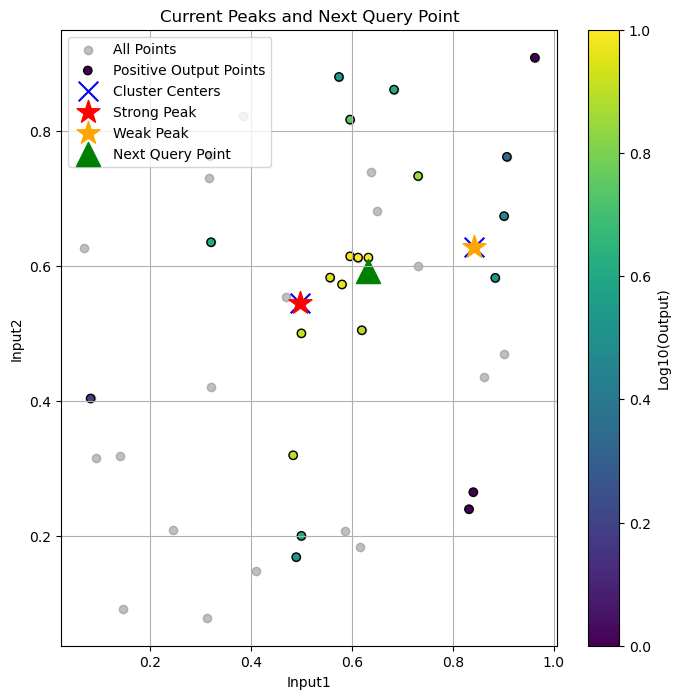

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import pandas as pd

##################################

function = 1
# Read the files
X_init = np.load("initial_inputs.npy")
y_init = np.load("initial_outputs.npy")
queries_file = "queries.txt"
observations_file = "observations.txt"

# Read queries data
import ast
queries_data = []
with open(queries_file, 'r') as f:
    for line in f:
        line = line.replace('array(', 'np.array(')
        queries_data.append(eval(line.strip()))

# Read observations data
observations_data = []
with open(observations_file, 'r') as f:
    for line in f:
        observations_data.append(eval(line.strip()))

# Extract the specified sub-arrays from queries
X = np.array([q[function - 1] for q in queries_data], dtype='float64')
y = np.array([o[function - 1] for o in observations_data])

# Find and remove duplicates
unique_indices = []
seen = set()
for i, x in enumerate(X):
    x_tuple = tuple(x)  # Convert to tuple for hashability
    if x_tuple not in seen:
        seen.add(x_tuple)
        unique_indices.append(i)

# Keep only unique queries and observations
X_unique = np.concatenate((X_init, X[unique_indices]))
y_unique = np.concatenate((y_init, y[unique_indices]))
queries_unique = [queries_data[i] for i in unique_indices]
observations_unique = [observations_data[i] for i in unique_indices]

# Save cleaned data to new files
with open("queries_unique.txt", "w") as f:
    for query in queries_unique:
        f.write(str(query) + "\n")

with open("observations_unique.txt", "w") as f:
    for obs in observations_unique:
        f.write(str(obs) + "\n")

# Save cleaned numpy arrays
np.save("initial_inputs_unique.npy", X_unique)
np.save("initial_outputs_unique.npy", y_unique)

#######################################

# Create a DataFrame from the inputs with specified column names
df_inputs = pd.DataFrame(X_unique, columns=['input1', 'input2'])

# Create a DataFrame for the outputs
df_outputs = pd.DataFrame(y_unique, columns=['output'])

# Concatenate the inputs and outputs DataFrames
data = pd.concat([df_inputs, df_outputs], axis=1)

# Display the resulting DataFrame
print(data)

#####################################

# Sort the DataFrame by 'output' column from lowest to highest
data = data.sort_values(by='output', ascending=True)

# Display the sorted DataFrame
print(data)

#################################

import os
# Set environment variable to suppress KMeans warning on Windows with MKL
os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
import matplotlib.pyplot as plt

# Step 1: Preprocess Data
def preprocess_data(data):
    """
    Filter DataFrame for positive outputs and extract coordinates and outputs.
    Args:
        data (pd.DataFrame): DataFrame with columns 'input1', 'input2', 'output'
    Returns:
        pd.DataFrame: Filtered DataFrame with positive outputs
        np.ndarray: Coordinates (input1, input2)
        np.ndarray: Corresponding output values
    """
    positive_data = data[data['output'] > 0]
    X_positive = positive_data[['input1', 'input2']].to_numpy()
    y_positive = positive_data['output'].to_numpy()
    return positive_data, X_positive, y_positive

# Step 2: Cluster Points to Estimate Current Peak Locations
def cluster_points(X_positive, y_positive):
    """
    Apply k-means clustering to estimate strong and weak peak locations.
    Args:
        X_positive (np.ndarray): Coordinates of positive output points
        y_positive (np.ndarray): Corresponding output values
    Returns:
        np.ndarray: Cluster centers (strong and weak peak estimates)
        np.ndarray: Strong peak coordinates
        np.ndarray: Weak peak coordinates
        float: Average output of strong peak cluster
        float: Average output of weak peak cluster
    """
    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(X_positive)
    cluster_centers = kmeans.cluster_centers_
    # Identify strong and weak clusters by average output
    cluster_outputs = []
    for i in range(2):
        cluster_points = y_positive[cluster_labels == i]
        avg_output = np.mean(cluster_points) if len(cluster_points) > 0 else 0
        cluster_outputs.append(avg_output)
    strong_cluster_idx = np.argmax(cluster_outputs)
    weak_cluster_idx = 1 - strong_cluster_idx
    strong_peak = cluster_centers[strong_cluster_idx]
    weak_peak = cluster_centers[weak_cluster_idx]
    strong_peak_output = cluster_outputs[strong_cluster_idx]
    weak_peak_output = cluster_outputs[weak_cluster_idx]
    return cluster_centers, strong_peak, weak_peak, strong_peak_output, weak_peak_output

# Step 3: Bayesian Optimization Setup
def fit_gaussian_process(X, y):
    """
    Fit a Gaussian Process to model the output landscape.
    Args:
        X (np.ndarray): Input coordinates
        y (np.ndarray): Output values
    Returns:
        GaussianProcessRegressor: Fitted GP model
    """
    kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(X, y)
    return gp

# Step 4: Expected Improvement Acquisition Function
def expected_improvement(X, X_sample, y_sample, gp, xi=0.01):
    """
    Compute Expected Improvement for selecting the next query point.
    Args:
        X (np.ndarray): Candidate points for evaluation
        X_sample (np.ndarray): Existing sample points
        y_sample (np.ndarray): Existing output values
        gp (GaussianProcessRegressor): Fitted GP model
        xi (float): Exploration-exploitation trade-off parameter
    Returns:
        np.ndarray: EI values for candidate points
    """
    mu, sigma = gp.predict(X, return_std=True)
    y_max = np.max(y_sample)
    with np.errstate(divide='warn'):
        Z = (mu - y_max - xi) / sigma
        ei = (mu - y_max - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0  # Avoid division by zero
    return ei

# Step 5: Select Next Query Point and Predict Output
def select_next_query_point(data, strong_peak):
    """
    Select the next query point using Bayesian optimization and predict its output.
    Args:
        data (pd.DataFrame): DataFrame with columns 'input1', 'input2', 'output'
        strong_peak (np.ndarray): Coordinates of the strong peak
    Returns:
        np.ndarray: Next query point
        float: Predicted output at the next query point
    """
    positive_data, X_positive, y_positive = preprocess_data(data)
    
    # Fit Gaussian Process to positive output points
    gp = fit_gaussian_process(X_positive, y_positive)
    
    # Create a dense grid for evaluating acquisition function
    grid_size = 50
    x_grid = np.linspace(0, 1, grid_size)
    y_grid = np.linspace(0, 1, grid_size)
    X_grid = np.array([[x, y] for x in x_grid for y in y_grid])
    
    # Mask out the strong peak region (radius 0.1)
    mask_radius = 0.1
    mask = np.ones(X_grid.shape[0], dtype=bool)
    for i, point in enumerate(X_grid):
        if np.sqrt((point[0] - strong_peak[0])**2 + (point[1] - strong_peak[1])**2) < mask_radius:
            mask[i] = False
    
    # Compute Expected Improvement for unmasked points
    ei = expected_improvement(X_grid, X_positive, y_positive, gp)
    ei[~mask] = -np.inf  # Set EI to -inf in masked region
    
    # Select point with highest EI
    next_point_idx = np.argmax(ei)
    next_point = X_grid[next_point_idx]
    
    # Predict output at the next query point
    predicted_output, _ = gp.predict([next_point], return_std=True)
    
    return next_point, predicted_output[0]

# Main function to find current peak estimates and next query point
def find_peaks_and_next_query(data):
    """
    Estimate current strong and weak peak locations, suggest next query point, and predict its output.
    Args:
        data (pd.DataFrame): DataFrame with columns 'input1', 'input2', 'output'
    Returns:
        tuple: (strong_peak, weak_peak, next_point, predicted_output, strong_peak_output, weak_peak_output)
    """
    # Step 1: Preprocess data and cluster points
    positive_data, X_positive, y_positive = preprocess_data(data)
    if len(X_positive) < 2:
        print("Insufficient positive output points for clustering. Selecting random point.")
        random_point = np.random.uniform(0, 1, 2)
        # Predict output at random point using GP
        gp = fit_gaussian_process(X_positive, y_positive)
        predicted_output, _ = gp.predict([random_point], return_std=True)
        return None, None, random_point, predicted_output[0], None, None
    
    cluster_centers, strong_peak, weak_peak, strong_peak_output, weak_peak_output = cluster_points(X_positive, y_positive)
    
    # Step 2: Select next query point and predict output
    next_point, predicted_output = select_next_query_point(data, strong_peak)
    
    # Step 3: Report results
    print(f"Current strong peak estimate: {strong_peak}, Output: {strong_peak_output:.4f}")
    print(f"Current weak peak estimate: {weak_peak}, Output: {weak_peak_output:.4f}")
    print(f"Next query point: {next_point}")
    print(f"Predicted output at next query point: {predicted_output:.4f}")
    
    # Step 4: Visualization
    plt.figure(figsize=(8, 8))
    plt.scatter(data['input1'], data['input2'], c='gray', alpha=0.5, label='All Points')
    plt.scatter(positive_data['input1'], positive_data['input2'],
                c=np.log10(positive_data['output'] + 1e-100),
                cmap='viridis', label='Positive Output Points', edgecolors='k')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='x',
                s=200, label='Cluster Centers')
    plt.scatter(strong_peak[0], strong_peak[1], c='red', marker='*', s=300,
                label='Strong Peak')
    plt.scatter(weak_peak[0], weak_peak[1], c='orange', marker='*', s=300,
                label='Weak Peak')
    plt.scatter(next_point[0], next_point[1], c='green', marker='^', s=300,
                label='Next Query Point')
    plt.xlabel('Input1')
    plt.ylabel('Input2')
    plt.title('Current Peaks and Next Query Point')
    plt.colorbar(label='Log10(Output)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return strong_peak, weak_peak, next_point, predicted_output, strong_peak_output, weak_peak_output

# Run the algorithm
# Assumes 'data' DataFrame is already defined with columns 'input1', 'input2', 'output'
strong_peak, weak_peak, next_point, predicted_output, strong_peak_output, weak_peak_output = find_peaks_and_next_query(data)
